In [30]:
import pandas as pd
import numpy as np
import umap
import gower

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import confusion_matrix,classification_report
from kmodes.kprototypes import KPrototypes
from numpy.linalg import eigh

In [31]:
plt.rcParams['font.sans-serif'] = ['PingFang TC', 'Arial Unicode MS']  # 黑體-繁體
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 125  
plt.rcParams['savefig.dpi'] = 150

In [32]:
df = pd.read_csv('spotify_processed_full.csv')

features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'speechiness', 'tempo', 'valence'
]

X = df[features]
print(X.shape)
display(X.head())

(1195666, 8)


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,0.02610,0.470,0.978,0.000011,0.304539,0.070179,117.906,0.503
1,0.01290,0.599,0.957,0.000071,0.144100,0.172271,103.680,0.489
2,0.02340,0.315,0.970,0.000002,0.115113,0.394067,149.749,0.370
3,0.16300,0.440,0.967,0.000004,0.114221,0.212689,96.752,0.574
4,0.00162,0.426,0.929,0.105000,0.075942,0.067752,127.059,0.539


In [33]:
# 初始化標準化轉換器
scaler = StandardScaler()

# 轉換資料
# fit: 計算每個特徵的平均值與標準差
# transform: 執行標準化 (x - mean) / std
X_scaled = scaler.fit_transform(X)
# 將結果轉換回 DataFrame 格式
# 保留原始索引 (Index) 與欄位名稱
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# 驗證標準化結果
# 觀察 mean 是否趨近於 0，std 是否趨近於 1
print("標準化後統計摘要 (Descriptive Statistics of Scaled Data):")
print(X_scaled.describe().round(2))

標準化後統計摘要 (Descriptive Statistics of Scaled Data):
       acousticness  danceability      energy  instrumentalness    liveness  \
count    1195666.00    1195666.00  1195666.00        1195666.00  1195666.00   
mean           0.00          0.00        0.00             -0.00        0.00   
std            1.00          1.00        1.00              1.00        1.00   
min           -1.16         -2.62       -1.74             -0.75       -1.27   
25%           -1.06         -0.73       -0.87             -0.75       -0.62   
50%           -0.15          0.04        0.05             -0.73       -0.43   
75%            1.08          0.74        0.87              1.16        0.34   
max            1.43          2.69        1.66              1.91        3.95   

       speechiness       tempo     valence  
count   1195666.00  1195666.00  1195666.00  
mean         -0.00       -0.00       -0.00  
std           1.00        1.00        1.00  
min          -0.62       -2.89       -1.59  
25%          

(樣本數: 100000)...


/Users/joshua_yang/Projects/spotify_cluster/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


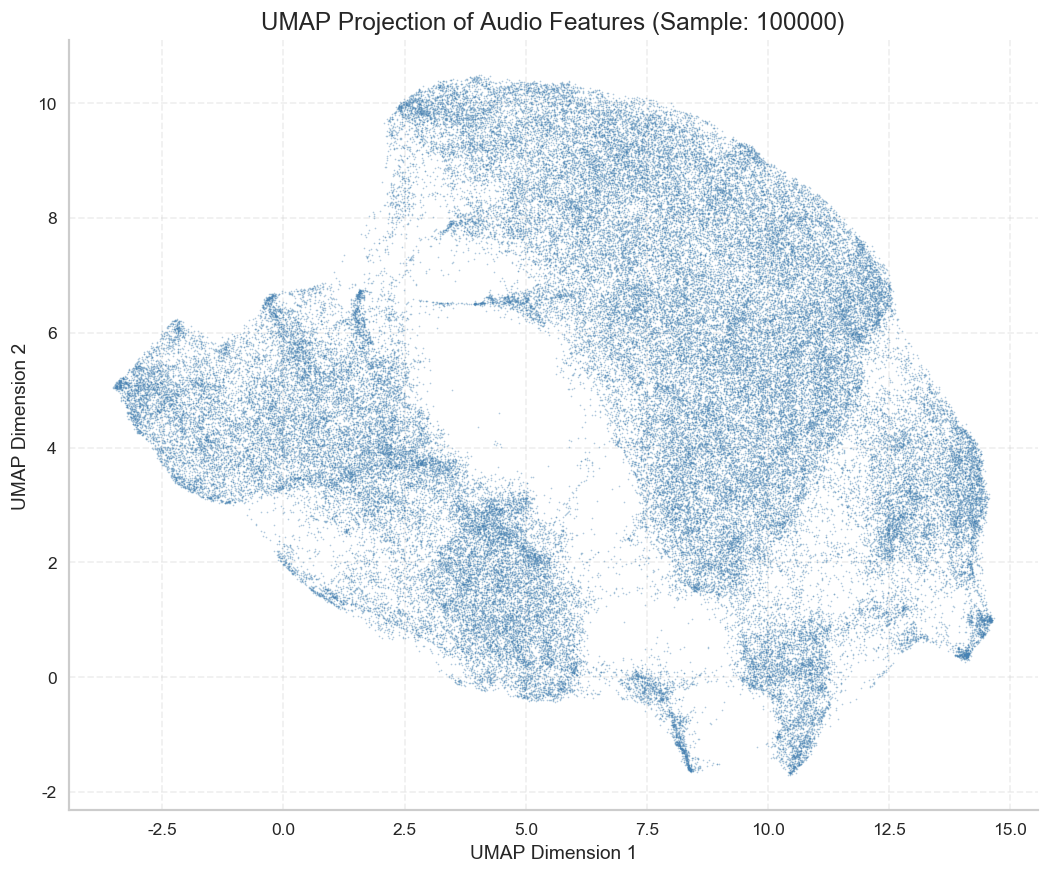

In [34]:
# UMAP 降維

# Sampling 
SAMPLE_SIZE = 100000
X_sample = X_scaled.sample(n=SAMPLE_SIZE, random_state=42)

print(f"(樣本數: {SAMPLE_SIZE})...")

# 訓練 UMAP
# n_neighbors: 控制局部結構與全域結構
# min_dist: 控制點之間的緊密度
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42,
    n_jobs=-1,  
    low_memory=False 
)

# 執行降維 (將 8 維特徵壓縮至 2 維)
embedding = reducer.fit_transform(X_sample)

# 將結果轉為 DataFrame 方便繪圖
df_umap = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
# 保留原始索引，以便未來需要時對照
df_umap.index = X_sample.index 

# 繪製 UMAP 散佈圖
plt.figure(figsize=(10, 8))
plt.scatter(df_umap['UMAP_1'], df_umap['UMAP_2'], s=0.5, alpha=0.3, c='steelblue')

plt.title(f'UMAP Projection of Audio Features (Sample: {SAMPLE_SIZE})', fontsize=14)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
sns.despine()
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

正在計算 K=2 到 K=15 的 Inertia (樣本數: 100000)...


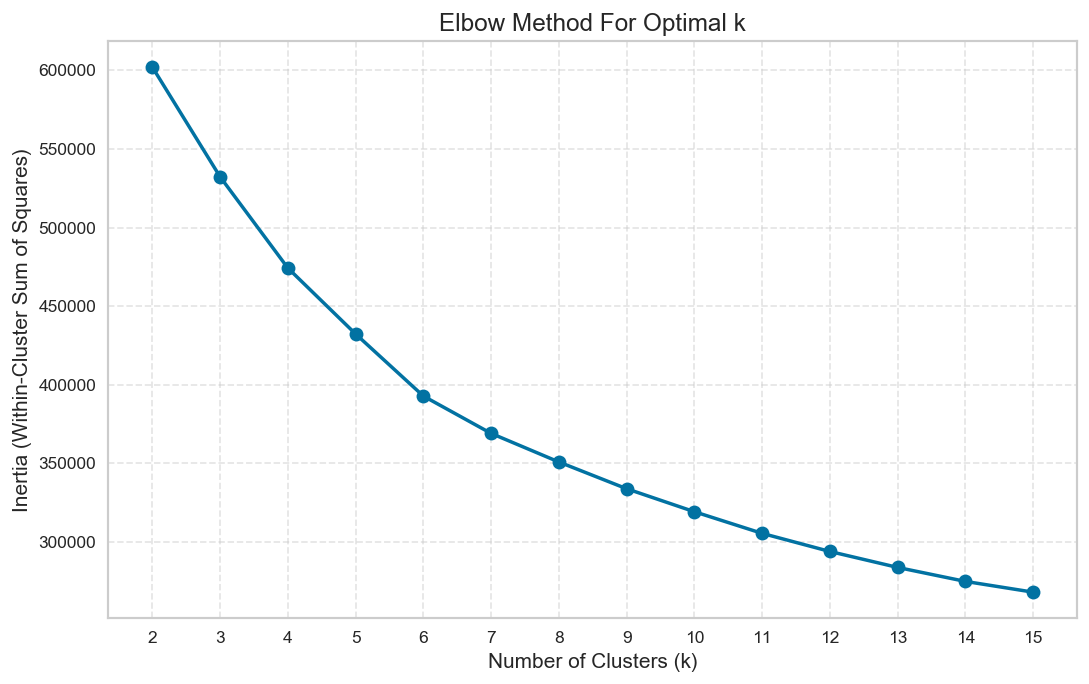

In [35]:
# 尋找最佳 K 值 (手肘法 Elbow Method)

# 設定測試範圍測試 2 到 15 群
k_range = range(2, 16)
inertias = []
print(f"正在計算 K=2 到 K=15 的 Inertia (樣本數: {len(X_sample)})...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)

# --- 繪製手肘圖 ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

plt.title('Elbow Method For Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.5)

# 標示可能的轉折點 (視覺輔助，需人工最後確認)
# 通常選擇斜率變平緩的第一個點
plt.show()

根據上面手肘圖，我認爲有以下幾點可以拿出來討論：
- 不管K切幾刀，曲線都蠻平滑的（誤差平方和隨著 K 值增加而穩定、平滑地下降），代表沒有一個是再增加就不划算的K。從音樂意義上討論，的確音樂之間並沒有存在明顯的邊界，他很有可能帶著重疊或是融合的特徵。

- 在數學上沒有得到明確的建議時。需要依賴一般對音樂分群的理解，透過domain對資料進行詮釋。也結合對圖片的觀察來決定K。
  - 如果基於圖片的結果：K=4 或 5在這個區間，Inertia 下降的幅度還算大。至少可以分出最粗略的類別，例如「純音樂」、「高能量舞曲」、「抒情慢歌」、「人聲/Podcast」。
  - K=8：曲線大約在 K=7 到 K=9 之間開始變得稍微平緩一點點。分析意義上，可以對應到我們認知的「曲風」，如 Hip-Hop, Rock, Electronic, Jazz, Classical 等。算是蠻有潛力兼顧解釋性與細緻度的平衡點。
  - K=12：可以試試看分更多群會不會更好。實際意義上，或許就是從主要分類中切分出更多的子分類。

正在測試 K = [5, 8, 12] 並繪製 UMAP 分佈圖...


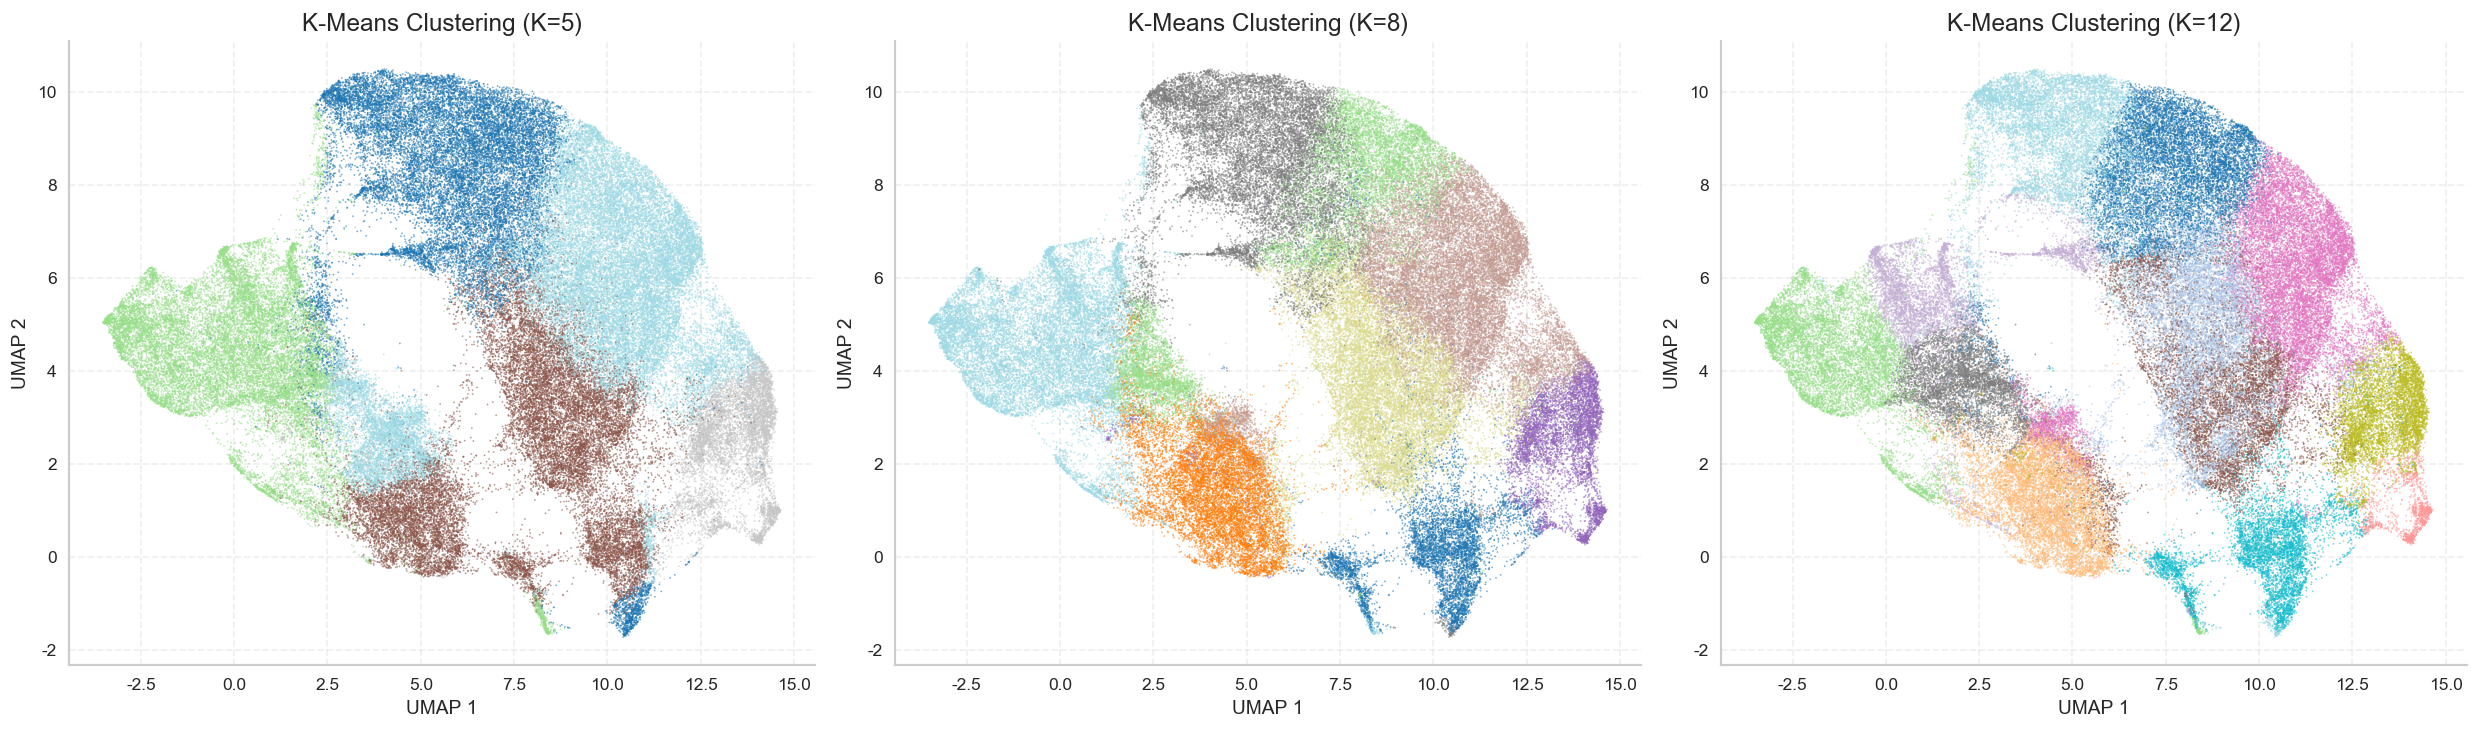

In [36]:
# --- 透過 UMAP 觀察不同 K 值的切分效果 ---

# 設定要測試的 K 值 (根據經驗選取小、中、大三個級距)
# 所謂經驗指的是一般來說歌曲分群的常見類別搭約落在5-12種，過低的話分類會不清晰過高的話，就必須差分出子類別。例如搖滾、金屬搖滾、鄉村搖滾等。
k_candidates = [5, 8, 12]

# 建立畫布
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

print(f"正在測試 K = {k_candidates} 並繪製 UMAP 分佈圖...")

for i, k in enumerate(k_candidates):
    # 訓練 K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample)
    
    # 繪圖
    sc = axes[i].scatter(
        df_umap['UMAP_1'], 
        df_umap['UMAP_2'], 
        c=cluster_labels, 
        cmap='tab20', 
        s=0.5, 
        alpha=0.5
    )
    
    axes[i].set_title(f'K-Means Clustering (K={k})', fontsize=14)
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')
    axes[i].grid(True, linestyle='--', alpha=0.3)
    
    # 移除多餘邊框
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

計算 K=4 到 12 的分群指標...
Silhouette 樣本數: 20000, CH Index 樣本數: 100000
  K=4: Silhouette=0.2045, CH_Index=23062.1
  K=5: Silhouette=0.1855, CH_Index=21398.6
  K=6: Silhouette=0.1934, CH_Index=20849.5
  K=7: Silhouette=0.1949, CH_Index=19564.6
  K=8: Silhouette=0.1832, CH_Index=18377.9
  K=9: Silhouette=0.1823, CH_Index=17536.9
  K=10: Silhouette=0.1873, CH_Index=16811.0
  K=11: Silhouette=0.1773, CH_Index=16262.2
  K=12: Silhouette=0.1807, CH_Index=15718.8


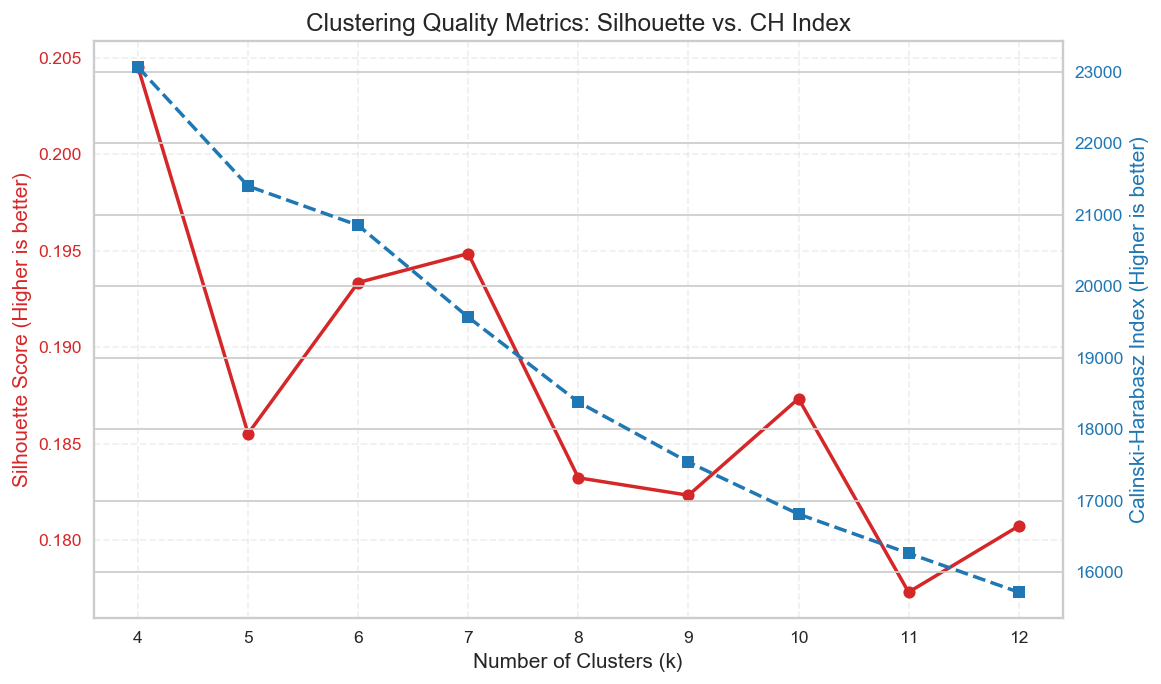

In [37]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# --- 設定參數 ---
SILHOUETTE_SAMPLE = 20000 
X_metrics_sample = X_scaled.sample(n=SILHOUETTE_SAMPLE, random_state=42)
# 測試 4 到 12 (涵蓋主要曲風的群值)
k_range = range(4, 13)

silhouette_scores = []
ch_scores = []

print(f"計算 K={k_range.start} 到 {k_range.stop-1} 的分群指標...")
print(f"Silhouette 樣本數: {SILHOUETTE_SAMPLE}, CH Index 樣本數: {len(X_sample)}")

for k in k_range:
    # 訓練 K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_sample) 
    
    # 計算 Silhouette Score (使用較小的驗證集，因為計算點到點之間的距離運算比較昂貴)
    labels_metrics = kmeans.predict(X_metrics_sample)
    sil_score = silhouette_score(X_metrics_sample, labels_metrics)
    silhouette_scores.append(sil_score)
    
    # 計算 Calinski-Harabasz Index 
    ch_score = calinski_harabasz_score(X_sample, labels)
    ch_scores.append(ch_score)
    
    print(f"  K={k}: Silhouette={sil_score:.4f}, CH_Index={ch_score:.1f}")

# --- 繪製雙軸圖表 ---
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Silhouette Score (Higher is better)', color=color, fontsize=12)
ax1.plot(k_range, silhouette_scores, marker='o', color=color, linewidth=2, label='Silhouette')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2 = ax1.twinx()  # 建立共用 X 軸的第二個 Y 軸
color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz Index (Higher is better)', color=color, fontsize=12)
ax2.plot(k_range, ch_scores, marker='s', color=color, linewidth=2, linestyle='--', label='CH Index')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Clustering Quality Metrics: Silhouette vs. CH Index', fontsize=14)
plt.show()

In [38]:
import ipywidgets as widgets
from ipywidgets import interact

# 預先計算好所有 K 值的標籤
print("正在預先計算 K=2~15 的分群結果")
cluster_results = {}
k_min, k_max = 2, 15

for k in range(k_min, k_max + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    cluster_results[k] = kmeans.fit_predict(X_sample)

print("預計算完成！")

# --- 定義互動繪圖函數 ---
def plot_umap_clusters(k):
    plt.figure(figsize=(10, 8))
    
    # 取得預先算好的標籤
    labels = cluster_results[k]
    
    # 繪圖
    plt.scatter(
        df_umap['UMAP_1'], 
        df_umap['UMAP_2'], 
        c=labels, 
        cmap='tab20', # 色譜夠多，適合分群
        s=0.5, 
        alpha=0.6
    )
    
    plt.title(f'K-Means Clustering on UMAP (K={k})', fontsize=14)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # 隱藏邊框
    sns.despine()
    plt.show()

# --- 建立互動介面 ---
interact(
    plot_umap_clusters, 
    k=widgets.IntSlider(min=k_min, max=k_max, step=1, value=8, description='Clusters (K):')
);

正在預先計算 K=2~15 的分群結果
預計算完成！


interactive(children=(IntSlider(value=8, description='Clusters (K):', max=15, min=2), Output()), _dom_classes=…

在決定分群數量（$k$ 值）時，我設定了 4 到 12 的範圍進行探索，以下嘗試結合「數學指標」與「視覺化分佈」來尋找最合理的k。
1. 歌曲分佈本身是一塊連綿的大陸。透過觀察前面的 UMAP 降維圖可以發現一個很有趣的現象：歌曲的分佈並不是幾個分散的小島，而是一塊完整且連續的大陸。我認為這很合理，畢竟音樂風格的變化通常是漸進的，很少有非黑即白的絕對界線。
2. 從數學的數值上討論的話，如果單純看 Silhouette Coefficient 和 CH Index 的數值，$k=4$ 的表現無疑是最好的；肉眼看 UMAP 圖，整塊大陸也確實可以粗略地被切分為上、下、左、右四個大區塊。**但回到應用層面，$k=4$ 並不能滿足我們對分群的需求。試想，如果全世界的音樂只被分成四類，那推薦系統的顆粒度就太粗了，無法捕捉到曲風之間細微的差異。**
3. 為了找到最佳折衷點，我嘗試鎖定數學指標上的「次高點」。
 - 透過折線圖來看 Silhouette Coefficient 與 CH Index 在 $k=7$ 時都出現了次高峰，顯示這裡有一個不錯的聚類結構。
 - 搭配 UMAP 散佈圖來看，$k=7$ 的邊界切分比起 $k=8$ 清晰許多。在 $k=8$ 時，顏色之間的混雜程度變高，感覺像是硬把原本同一群的東西拆開；相對地，$k=7$ 在維持多樣性的同時，仍保有較好的區隔度。

**結論:雖然數學上分 4 群最穩，但為了讓分群結果在實際上更有意義，我決定採用 $k=7$ 作為最終分群數。這是我認為在統計表現與實際應用之間，所能找到的最佳平衡點。**

In [44]:
kmeans_full = KMeans(n_clusters=7, random_state=42)
kmeans_full.fit(X_scaled)

,n_clusters,7
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [45]:
df['cluster'] = kmeans_full.labels_
X_scaled['cluster'] = kmeans_full.labels_

# 特徵轉換 A: 年代 (Decade)
# 將年份 (year) 轉換為年代區間 (例如: 1980s)
df['decade'] = (df['year'] // 10) * 10
df['decade'] = df['decade'].astype(str) + 's'

# 特徵轉換 B: 歌曲長度 (Duration)
# 將毫秒 (ms) 轉換為分鐘 (min)，保留兩位小數
df['duration_min'] = round(df['duration_ms'] / 60000, 2)

# 特徵轉換 C: 古典樂關鍵字標記 (輔助判斷)
classical_keywords = ['Symphony', 'Concerto', 'Sonata', 'Op.', 'Major', 'Minor']
df['is_classical'] = df['name'].apply(lambda x: any(k in str(x) for k in classical_keywords))

print("-" * 50)
print(f"成功處理 {len(df)} 筆資料！預覽如下：")
print(df[['name', 'artists', 'cluster', 'year', 'decade', 'duration_min']].head())
print("-" * 50)

--------------------------------------------------
成功處理 1195666 筆資料！預覽如下：
                    name                       artists  cluster  year decade  \
0                Testify  ['Rage Against The Machine']        6  1999  1990s   
1        Guerrilla Radio  ['Rage Against The Machine']        2  1999  1990s   
2       Calm Like a Bomb  ['Rage Against The Machine']        0  1999  1990s   
3              Mic Check  ['Rage Against The Machine']        6  1999  1990s   
4  Sleep Now In the Fire  ['Rage Against The Machine']        6  1999  1990s   

   duration_min  
0          3.50  
1          3.44  
2          4.98  
3          3.56  
4          3.43  
--------------------------------------------------


In [48]:
# 檢查每一群的數量
print(df['cluster'].value_counts().sort_index())

cluster
0     78414
1     80813
2    275702
3    199119
4    229232
5    137563
6    194823
Name: count, dtype: int64


In [49]:
# ---------------------------------------------------------
# 分群結果統計摘要 (Cluster Statistical Summary)
# ---------------------------------------------------------

# 定義需要觀察的數值欄位
# 包含音訊特徵 (Audio Features) 與元數據 (Metadata)
target_columns = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'speechiness', 'tempo', 'valence', 
    'year', 'duration_min', 'explicit'
]

# 針對分群結果進行分組，並計算各欄位的平均值
cluster_summary = df.groupby('cluster')[target_columns].mean()

# 加入各群組的資料筆數 (Size)，以了解群組規模
cluster_summary['count'] = df['cluster'].value_counts()

# 整理表格格式：
# 1. 將 'count' 移到第一欄，方便閱讀
cols = ['count'] + [col for col in cluster_summary.columns if col != 'count']
cluster_summary = cluster_summary[cols]

# 2. 數值取小數點後 3 位，保持版面整潔
cluster_summary = cluster_summary.round(3)

# 3. 針對特定欄位做格式微調 (年份轉整數、Explicit 轉百分比概念)
# 為了顯示方便，這裡僅對顯示用的副本進行處理，不影響原變數
display_summary = cluster_summary.copy()
display_summary['year'] = display_summary['year'].astype(int)
display_summary['explicit_rate'] = (display_summary['explicit'] * 100).round(1).astype(str) + '%'

# 移除原始的 explicit 欄位，改用百分比顯示
display_summary = display_summary.drop(columns=['explicit'])

print("=== Spotify 分群統計摘要表 (K-Means, k=7) ===")
print("說明：數值為該群組的平均值 (Mean)")
display(display_summary)

# ---------------------------------------------------------
# 進階觀察：找出極值 (Feature Highlights)
# ---------------------------------------------------------
print("\n=== 各特徵最大值所在的群組 (Cluster with Max Value) ===")
# 找出每個特徵平均值「最高」的群組是哪一群，快速捕捉群組特色
idxmax = cluster_summary.drop(columns=['count']).idxmax()
for feature, cluster_id in idxmax.items():
    print(f"{feature:15s}: Cluster {cluster_id}")

=== Spotify 分群統計摘要表 (K-Means, k=7) ===
說明：數值為該群組的平均值 (Mean)


,count,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,year,duration_min,explicit_rate
cluster,,,,,,,,,,,,
0,78414,0.336,0.659,0.599,0.041,0.218,0.348,113.788,0.533,2010,3.476,44.2%
1,80813,0.330,0.462,0.664,0.183,0.535,0.081,120.388,0.457,2006,4.572,6.3%
2,275702,0.262,0.660,0.656,0.031,0.144,0.059,117.284,0.690,2007,3.731,8.2%
3,199119,0.878,0.315,0.163,0.826,0.124,0.045,103.639,0.188,2005,4.881,0.2%
4,229232,0.788,0.439,0.246,0.046,0.135,0.044,109.782,0.296,2005,3.997,1.2%
5,137563,0.269,0.575,0.637,0.805,0.139,0.055,124.316,0.500,2008,4.376,1.7%
6,194823,0.078,0.398,0.783,0.132,0.170,0.072,139.232,0.358,2009,4.252,7.3%



=== 各特徵最大值所在的群組 (Cluster with Max Value) ===
acousticness   : Cluster 3
danceability   : Cluster 2
energy         : Cluster 6
instrumentalness: Cluster 3
liveness       : Cluster 1
speechiness    : Cluster 0
tempo          : Cluster 6
valence        : Cluster 2
year           : Cluster 0
duration_min   : Cluster 3
explicit       : Cluster 0


In [52]:
from sklearn.mixture import GaussianMixture
import time

# ---------------------------------------------------------
# 1. 高斯混合模型 (GMM) 訓練設定
# ---------------------------------------------------------
feature_cols = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'speechiness', 'tempo', 'valence'
]

available_cols = [c for c in feature_cols if c in X_scaled.columns]

gmm = GaussianMixture(
    n_components=7,
    covariance_type='full',
    max_iter=300,
    n_init=1,
    init_params='kmeans',
    tol=1e-4,
    random_state=42,
    verbose=1,
    verbose_interval=10
)

# ---------------------------------------------------------
# 2. 模型訓練
# ---------------------------------------------------------

print(f"開始訓練 GMM 模型 (資料量: {len(X_scaled)} 筆)...")
start_time = time.time()

gmm.fit(X_scaled[available_cols])

end_time = time.time()
print(f"GMM 訓練完成！耗時: {end_time - start_time:.2f} 秒")

# ---------------------------------------------------------
# 3. 預測與資料合併
# ---------------------------------------------------------

print("正在計算分群結果...")

gmm_labels = gmm.predict(X_scaled[available_cols])

# 將結果寫入 DataFrame
df['cluster_gmm'] = gmm_labels
X_scaled['cluster_gmm'] = gmm_labels

# ---------------------------------------------------------
# 4. (進階) 軟分群機率觀察
# ---------------------------------------------------------
sample_idx = 0
probs = gmm.predict_proba(X_scaled.iloc[[sample_idx]][available_cols])

print(f"\n範例歌曲 ({df.iloc[sample_idx]['name']}) 的隸屬機率分佈：")
with np.printoptions(precision=3, suppress=True):
    print(probs)

print("-" * 50)
print("GMM 分群完成。")
print(df['cluster_gmm'].value_counts().sort_index())

# 5. 比較兩種分群的差異矩陣
print("\n[ K-Means vs GMM 對照表 ]")
print(pd.crosstab(df['cluster'], df['cluster_gmm']))

開始訓練 GMM 模型 (資料量: 1195666 筆)...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged.
GMM 訓練完成！耗時: 27.12 秒
正在計算分群結果...

範例歌曲 (Testify) 的隸屬機率分佈：
[[0.983 0.    0.    0.01  0.    0.007 0.   ]]
--------------------------------------------------
GMM 分群完成。
cluster_gmm
0    205994
1    120921
2    151431
3    308977
4    104942
5     93544
6    209857
Name: count, dtype: int64

[ K-Means vs GMM 對照表 ]
cluster_gmm      0      1       2       3      4      5      6
cluster                                                       
0            67719      3       0       0  10692      0      0
1            40060  10922       0     229  28145   1416     41
2            57717  11032      18  132580  11919  38702  23734
3                0    153  121569       0  12391      0  65006
4            12368      0   28506  122232   5429  35697  25000
5                0  33592    1338       0  22455      0  80178
6    

1. 選擇其他種分群方法，跟 k-means做比較，解釋一下你使用的分群是什麼方法，跟k-means 有什麼不一樣?

    面對分佈呈現連續的「大陸塊」狀的音樂資料，K-Means 預設將所有群組視為大小相近的「正圓形」，這種限制對音樂資料來說實在有點太死板。因此，我選擇高斯混合模型 (GMM) 作為對照組，希望能捕捉到風格之間的過渡地帶。GMM 和 K-Means 最大的不同，簡單來說有兩個
  - 形狀不再受限：K-Means 只能單純用歐式距離畫圓，強迫資料要長得像球體；但 GMM 引入了「共變異數」，讓群組可以是長短不一的橢圓形。這更符合真實狀況，畢竟某些曲風可能在能量上變化很大（拉得很長），但在節奏上卻很固定（很窄），橢圓形更能包容這種特徵。
  - 分群不再非黑即白：K-Means 是硬性切分，一翻兩瞪眼；但 GMM 計算的是「機率」（例如：這首歌 70% 像爵士，30% 像藍調）。這種軟分群 (Soft Clustering) 的方式，更貼近音樂風格原本就是漸進、混血的本質，也能讓我們看到那些被 K-Means 忽略掉的細微過渡結構。

---

2. 描述你的分群輪廓，以及這個分群輪廓對於你的主題有什麼幫助

 - 在作業中，我將數據以非監督式學習的方式切分為七群，從七個群組的數據輪廓來看，這些歌曲已經大略依照「聽感」與「樂器編制」被自動區分開來，以下針對這些分群搭配資料本身的標籤進行分群意義的說明。
  首先是 Cluster 3 與 Cluster 5 。這兩群的 Instrumentalness（樂器感）都在 0.8 以上，非常高，代表它們幾乎沒有歌詞。但更有趣的，可以進一步比較它們的能量差異：Cluster 3 是所有群組中能量最低、最原聲（Acousticness 最高）且歌曲長度最長的，這蠻明顯屬於「古典樂、配樂或療癒系的純音樂」；相對地，Cluster 5 雖然也是純音樂，但它的能量與節奏感（Danceability）都維持在中高水準，這應該屬於「電子舞曲（EDM）、House 或 Trance」的特徵。
  
    雖然我相信這裡面一定還可以切分得更細緻，但是光是能把「安靜的純音樂」跟「吵雜的純音樂」分開，就證明了這個目前模型對音樂聽感特徵區分的有效性。

 - 接著是人聲為主的群組，Cluster 0 有最高的 Speechiness（說話感）與 Explicit（限制級標籤，高達 44.2%），加上它是平均年份最新的群組，我認為這一群很有可能是「現代嘻哈（Hip-Hop）與饒舌音 
   樂」。相反地， Cluster 4，它雖然 Acousticness 很高，但 Instrumentalness 很低，代表它是原聲配樂器加上人聲演唱，我認為這比較像是「不插電（Unplugged）或民謠抒情歌」會出現的特徵。
 - 在情緒與氛圍方面，Cluster 2 有最高的 Valence（正向情緒）與 Danceability（舞曲感），可以推測這群音樂聽起來大概是「快樂、讓人想隨之起舞」流行歌曲那種感覺。而 Cluster 6 則有最高的 Tempo（139 BPM）與 Energy，我認為應該是「高強度的搖滾、金屬或健身用的快節奏音樂」。最後，Cluster 1 有著較高的的 Liveness（現場感），這群很可能是「演唱會現場錄音（Live）」的集合。
 - 整體來說，目前的輪廓描繪對歌曲分類有蠻大的幫助。在沒有提供任何歌曲標籤的狀況下，雖然目前的分類就要拿來做推薦系統，顯微粗糙了些，但至少可以做到，如果用戶想要「專注工作」，可以直接鎖定 Cluster 3（安靜純音樂）；如果用戶想要「派對助興」，我可以推薦 Cluster 2（快樂舞曲）或 Cluster 0（嘻哈）；如果是「運動健身」，Cluster 6（高強度）。

---

3. 當你的資料及測試集變成 2:8 的時候，對你的資料有什麼影響

    因為我們是非監督式學習，跟助教提供的程式碼，有明確的存活標籤可以對照不一樣。所以我是直接用百分百的資料訓練，接著透過 metadata 來進行分群品質的確認。針對問題進一步討論，如果我們將策略改為只用 20% 的資料來訓練模型，剩下的 80% 則是用預測的方式來貼標籤，我認為對這份音樂資料主要會有兩個層面的影響：

    在大方向的結構上，影響其實微乎其微： 因為原始資料量為 120 萬筆資料，即便只取 20%（約 24 萬筆），這個樣本數在統計上已經大到足以代表母體了。就像我們前面提到的，音樂特徵是一塊連續的大陸，只要 20% 的取樣夠隨機，這塊大陸的輪廓（Main Structure）基本上都能被抓出來。主要的七大群組（如嘻哈、古典、舞曲）的核心位置應該會相當穩定，不會因為資料變少就憑空消失或大移位。

    但在「邊緣地帶」與「稀有曲風」上，可能會丟失細節： 雖然大陸的形狀還在，但「海岸線」可能會畫得沒那麼準。若某些小眾曲風（例如某種特定的實驗音樂）在整體佔比極低，它們很有可能在 20% 的抽樣中完全沒被選到。這會導致模型在建立時「不知道有這群人的存在」，最後在預測那 80% 的資料時，這些小眾歌曲就會被強制歸類到旁邊比較大的主流群組裡（被同化了），導致分群的顆粒度變粗，失去了捕捉長尾曲風的能力。

---

4. 我們還可以怎麼樣調整我們的分群
    
    雖然目前的 K=7 分群結果已經能區分出基本的聽感功能，但若要讓這個系統真的變成一個堪用的推薦系統，我認為可能幾個方向可以調整：

 - 採取「階層式」二次分群 ： 目前的七大群還是太廣泛了。例如 Cluster 3 被我們定義為「古典/純音樂」，但裡面其實混雜了「單一鋼琴獨奏」跟「氣勢磅礡的交響樂」，這兩者的聽感差異其實很大。我們可以在 Cluster 3 裡面再跑一次 K-Means（假設 k=3），把它細拆成獨奏、交響樂、環境白噪音。這種「先分大類、再分小類」的階層式做法，會比直接把全體硬拆成 20 群來得精準且好解釋。

 - 引入特徵權重 (Feature Weighting) 或降維處理： 目前我們將所有特徵（如 Energy, Year, Duration）視為同等重要，但實際上，聽眾在區分曲風時，可能對「有沒有人聲 (Instrumentalness)」的敏感度遠高於「歌曲長度」。我們可以嘗試調整特徵的權重，或是先透過 PCA 降維來過濾掉雜訊（例如年份可能跟曲風無絕對關係，反而是種干擾），讓分群更聚焦在真正的「聽感特徵」上。

 - 結合 GMM 的「信心分數」來過濾推薦名單： 既然我們已經跑了 GMM，我們可以利用它提供的「機率值」來優化推薦。在推薦歌單時，我們只推那些「隸屬機率 > 90%」的歌曲（也就是該群組的核心成員），而把那些模稜兩可的邊緣歌曲過濾掉。這樣可以確保推給用戶的每一首歌都是該曲風的「純正代表作」，大幅提升用戶對推薦系統的信任感。


